In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data1 = pd.read_csv('/Users/gyujin/Downloads/refined_data.csv')
data1.head()

,Unnamed: 0,기업명,매출액(백만원),순이익(백만원),구주매출,희망공모가(최저),희망공모가(최고),청약경쟁률(:1),확정공모가(원),경쟁률(:1),의무보유확약(:1),시초/공모%(수익률),공모가(원),시초가(원),상장일
0,0,에이치피에스피,61174.0,17658.0,1.00,23000.0,25000.0,1159.05,25000,1511.36,42.54,100.00,25000,50000,20220715
1,1,영창케미칼,60760.0,2506.0,0.83,15000.0,18600.0,682.13,18600,1616.27,5.92,-1.08,18600,18400,20220714
2,2,넥스트칩,10383.0,-13496.0,1.00,9900.0,11600.0,1727.38,13000,1623.41,11.58,31.92,13000,17150,20220701
3,3,위니아에이드,418527.0,24895.0,1.00,14200.0,16200.0,111.26,16200,955.00,1.39,-9.88,16200,14600,20220623
4,4,레이저쎌,3879.0,-7665.0,1.00,12000.0,14000.0,1845.11,16000,1442.95,12.43,28.75,16000,20600,20220624


In [3]:
from sklearn.model_selection import train_test_split
x= data1[["매출액(백만원)","순이익(백만원)","구주매출","희망공모가(최저)","희망공모가(최고)","청약경쟁률(:1)","확정공모가(원)","경쟁률(:1)","의무보유확약(:1)","공모가(원)","시초가(원)"]]
y= data1["시초/공모%(수익률)"]

In [4]:
x_train, x_test,y_train,y_test = train_test_split(x, y, train_size=0.8,test_size=0.2,random_state = 1)
#8:2의 비율로 training, test set 분리

In [5]:
print(x_train.shape)
print(x_test.shape)
print(y_test)

(316, 11)
(80, 11)
174      5.31
358     78.57
249    100.00
273      9.03
339      9.52
        ...  
146     73.53
287      0.42
222     24.17
159     81.56
23     100.00
Name: 시초/공모%(수익률), Length: 80, dtype: float64


In [6]:
#pip install xgboost

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import explained_variance_score

In [8]:
pipe = Pipeline([('regressor', RandomForestRegressor())])
search_space = [
                {
                 'regressor': [RandomForestRegressor(random_state=0)],
                 'regressor__n_estimators': [100, 150, 200],
                 'regressor__max_depth': [3, 4, 5]
                },
                
                {
                 'regressor': [XGBRegressor()],
                 'regressor__max_depth': [3],
                 'regressor__n_estimators': [300],
                 'regressor__eta': [0.02, 0.1],
                 'regressor__subsample': [0.5, 0.6],
                 'regressor__seed':[0]
                },
                
                {
                 'regressor': [DecisionTreeRegressor(random_state=0)],
                 'regressor__min_samples_split':[3, 4, 5],
                 'regressor__max_depth': [3, 4, 5]
                }
               ]

In [9]:
kf = KFold(n_splits=5,random_state=None)
grid_search = GridSearchCV(pipe,search_space, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train.values.ravel())

print('best params:', grid_search.best_params_) 
# grid_dclf.best_params_: 최적 하이퍼파라미터

best params: {'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...), 'regressor__eta': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__seed': 0, 'regressor__subsample': 0.6}


In [10]:
print('best estimator:', grid_search.best_estimator_)
#grid_dclf.best_estimator_: 최적화 모델

best estimator: Pipeline(steps=[('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eta=0.1,
                              eval_metric=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=300, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0, ...))])


In [11]:
import xgboost
xgb_model = xgboost.XGBRegressor(n_estimators=300, learning_rate=0.100000001, gamma=0, subsample=0.6,
                           colsample_bytree=1, max_depth=3)

print(len(x_train), len(x_test))
xgb_model.fit(x_train,y_train)

316 80


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

/Users/gyujin/miniforge3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55148 (\N{HANGUL SYLLABLE HYI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyujin/miniforge3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyujin/miniforge3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyujin/miniforge3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyujin/miniforge3/envs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) miss

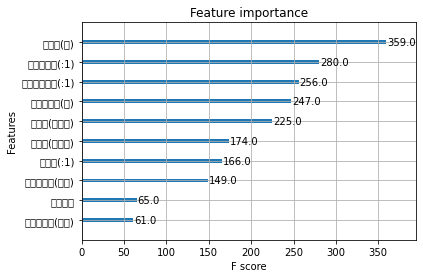

In [12]:
xgboost.plot_importance(xgb_model)

In [13]:
y_predict = xgb_model.predict(x_test)
y_predict

array([ 14.914986  ,  43.03278   ,  91.80231   ,  30.238981  ,
        -0.57546794,  53.6444    ,  94.85368   ,  44.625538  ,
        27.405104  ,  -5.042591  , 105.89659   ,  94.83082   ,
        30.415792  ,  -8.162063  ,  44.410984  ,  -9.590999  ,
        17.698483  ,  29.560352  ,  54.38128   ,  42.245083  ,
        28.437061  ,  14.053684  ,  15.824256  ,  11.393738  ,
       -11.930723  ,  92.25876   ,  18.457747  ,  96.46017   ,
        57.385468  ,  23.06639   ,  64.26522   ,   6.085275  ,
        87.22263   ,  66.01172   ,  80.61292   ,  64.508125  ,
        -4.516083  ,  94.759964  ,  79.3002    ,  78.3613    ,
        19.43244   ,  81.06044   ,  49.57772   ,  49.57757   ,
        26.492573  ,   9.831065  ,  70.3227    , 101.37789   ,
        20.81126   ,  -0.2116029 ,  56.002445  ,  38.723736  ,
        -0.4916276 ,  81.505684  ,   8.994231  ,  97.16388   ,
        31.634937  ,  10.366146  ,  16.93194   ,  85.46653   ,
        20.701649  ,  18.526033  ,  73.48188   , 105.45

In [14]:
r_sq = xgb_model.score(x_train, y_train) #r-sq= r2 결정계수
print(r_sq)
print(explained_variance_score(y_predict,y_test)) # explained variance score = 설명분산점수

0.9978014387864986
0.7483038500163379


In [15]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


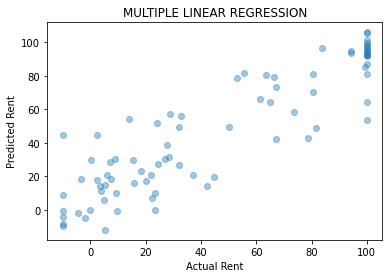

In [16]:
plt.scatter(y_test, y_predict, alpha = 0.4)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [17]:
from sklearn.metrics import mean_absolute_error
mae_test=mean_absolute_error(y_test,y_predict)
#수치가 낮을수록 정확도가 높음

In [18]:
from sklearn.metrics import mean_squared_error
mse_test=mean_squared_error(y_test, y_predict)
#수치가 낮을수록 정확도가 높음

In [19]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, y_predict)

In [20]:
print('xgboost regression: Mean squared error: %f' %(mse_test)) 
print('xgboost regression: Mean_absolute_error: %f' %(mae_test)) 
print('xgboost regression: r2_score: %f' %(r2_score)) 

xgboost regression: Mean squared error: 320.376969
xgboost regression: Mean_absolute_error: 13.177783
xgboost regression: r2_score: 0.797855
